# GridMET Future Projections 

### Historical Data Analysis

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
import xarray as xr
import geopandas as gpd
import pandas as pd
# requires cartopy to be installed
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import cartopy.crs as ccrs # for projection
import cartopy.feature as cfeature # for map features
from cartopy.util import add_cyclic_point
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
#from matplotlib.colors import TwoSlopeNorm
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import sys
import matplotlib.patches as mpatches


In [3]:
filein = '/data/keeling/a/ctavila2/7_bootstrapping/gridmet_native_gridtmaxrhmin_oregon'
annual_mean = xr.open_dataset(filein)

In [4]:
spatial_aggregate = annual_mean.mean(dim=['time'])
yearly_mean = annual_mean.groupby('time.year').mean(dim='time')
fwi_benchmark = yearly_mean.std(dim='year')

/data/keeling/a/ctavila2/mambaforge/envs/FWI/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [5]:
fwi = yearly_mean
poly_coeffs = fwi.FWI.polyfit(dim="year", deg=1).rename({"polyfit_coefficients":"FWI"}) 
poly_fits = xr.polyval(coord=fwi["year"], coeffs=poly_coeffs)
trendline = poly_coeffs.sel(degree=1).FWI

trendline_values = trendline * yearly_mean["year"] + poly_coeffs.sel(degree=0).FWI 
# this gives me my mx+b value at each point, essentially giving the predicted value from the linear regression
residuals = yearly_mean.FWI - trendline_values
standard_deviation_residuals = residuals.std(dim='year')

/data/keeling/a/ctavila2/mambaforge/envs/FWI/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


### Historical Plots

#### Historical Average

Text(0.5, 1.0, 'gridMET Historical Average')

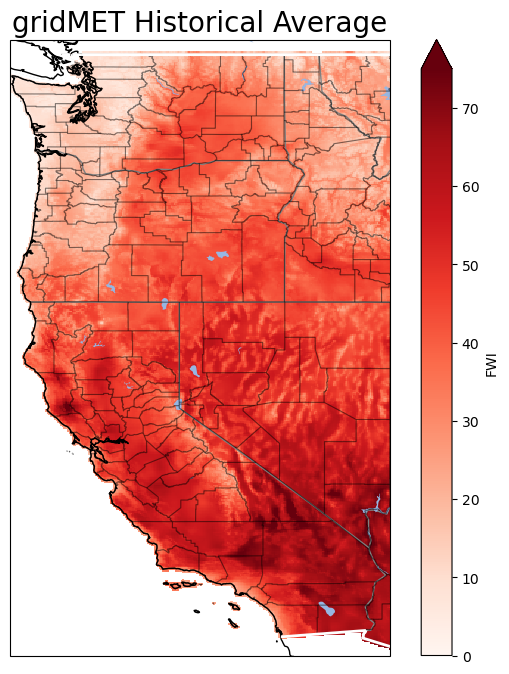

In [6]:
reader = shpreader.Reader('/data/keeling/a/ctavila2/2_maps/county_shapefile/countyl010g.shp')
counties = list(reader.geometries())

COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

scale = '110m'
states110 = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale=scale,
            facecolor='none',
            edgecolor='r')


cmap='Reds'

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})

spatial_aggregate.FWI.plot(ax=ax,cmap=cmap,vmin=0,vmax=75)


ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '110m', edgecolor='gray', facecolor='none'))
ax.coastlines()
ax.add_feature(cfeature.LAKES)
ax.add_feature(COUNTIES, linewidth=0.8, alpha=0.5, facecolor='none', edgecolor='black')
ax.add_feature(cfeature.BORDERS, linewidth=2, edgecolor='white')


plt.title('gridMET Historical Average', fontsize=20)
#plt.savefig(f'/data/keeling/a/ctavila2/2024_FWI_CMIP5_Ensemble_Avila/final_figures/figure_1_rcp85_gridmet_historical_v2/avg/seven_five/0_0_0_GRIDMET_Historical_Average_tmaxrhmin_native_75{cmap}')


#### Historical Trend

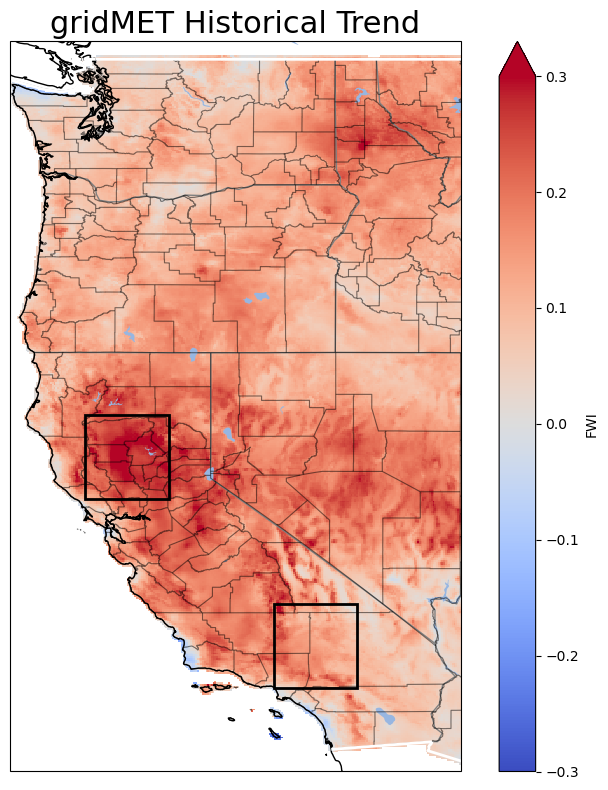

In [28]:
reader = shpreader.Reader('/data/keeling/a/ctavila2/2_maps/county_shapefile/countyl010g.shp')
counties = list(reader.geometries())

COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

scale = '110m'
states110 = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale=scale,
            facecolor='none',
            edgecolor='r')


cmap='coolwarm'

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})
trendline.plot(ax=ax,cmap=cmap,vmin=-.3,vmax=.3)


ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '110m', edgecolor='gray', facecolor='none'))
ax.coastlines()
ax.add_feature(cfeature.LAKES)
ax.add_feature(COUNTIES, linewidth=0.8, alpha=0.5, facecolor='none', edgecolor='black')
ax.add_feature(cfeature.BORDERS, linewidth=2, edgecolor='white')


plt.title('gridMET Historical Trend', fontsize=22)


norcal_box = mpatches.Rectangle(
    xy=(-123, 38.5), width=2.0, height=2.0,
    linewidth=2, edgecolor='black', facecolor='none',
    transform=ccrs.PlateCarree(), label='NorCal', linestyle='-', 
)

# Socal box: [-118.5, -116.5], [34, 36]
socal_box = mpatches.Rectangle(
    xy=(-118.5, 34.0), width=2.0, height=2.0,
    linewidth=2, edgecolor='black', facecolor='none',
    transform=ccrs.PlateCarree(), label='SoCal', linestyle='-', 
)

ax.add_patch(norcal_box)
ax.add_patch(socal_box)
fig.tight_layout()

plt.savefig(f'/data/keeling/a/ctavila2/2024_FWI_CMIP5_Ensemble_Avila/final_figures/figure_1_rcp85_gridmet_historical_v2/0_1_0_GRIDMET_Historical_Trend_tmaxrhmin_native_90{cmap}_box2')


#### Historical Std. Dev. Resids (rmse)

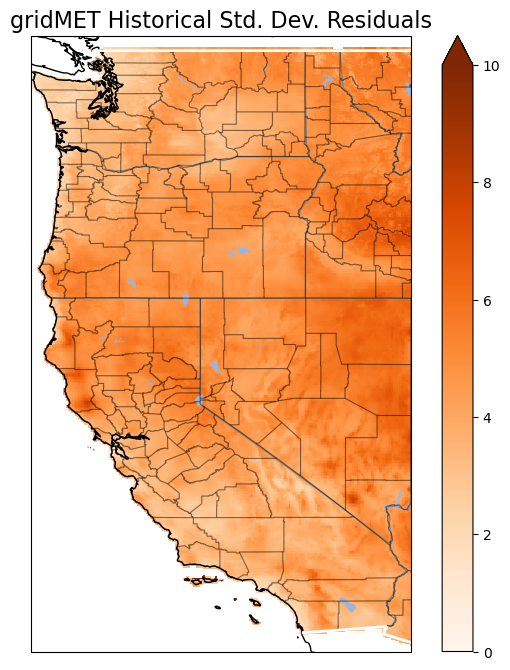

In [18]:
reader = shpreader.Reader('/data/keeling/a/ctavila2/2_maps/county_shapefile/countyl010g.shp')
counties = list(reader.geometries())

COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

scale = '110m'
states110 = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale=scale,
            facecolor='none',
            edgecolor='r')


cmap='Oranges'

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})
standard_deviation_residuals.plot(ax=ax,cmap=cmap,vmin=0,vmax=10)


ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '110m', edgecolor='gray', facecolor='none'))
ax.coastlines()
ax.add_feature(cfeature.LAKES)
ax.add_feature(COUNTIES, linewidth=0.8, alpha=0.5, facecolor='none', edgecolor='black')
ax.add_feature(cfeature.BORDERS, linewidth=2, edgecolor='white')


plt.title('gridMET Historical Std. Dev. Residuals', fontsize=16)
plt.savefig('/data/keeling/a/ctavila2/2024_FWI_CMIP5_Ensemble_Avila/final_figures/figure_1_rcp85_gridmet_historical_v2/0_2_0_GRIDMET_Historical_Standard_Deviation_tmaxrhmin_native_90')


### Future Projections bootstrap

#### 2090

In [7]:
# this is basically an array which all points are replaced with my bootstrapped values, no time coordinate so every point 
# has a single value 
blank = residuals.mean(dim=['year'])

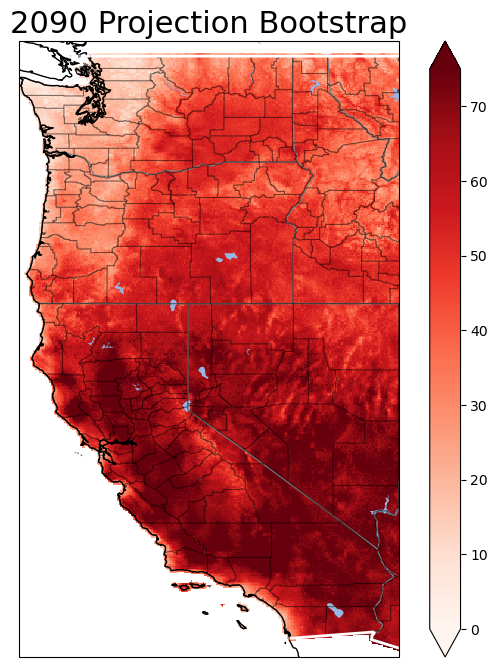

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Number of bootstrap iterations, 18 because 18 CMIP5 models 
num_iterations = 18

num_plots = 1
for i in range(num_plots):
    booted_trend_slope = blank.copy(deep=True)
    # iterates at each point
    for lon in residuals.lon.values:
        for lat in residuals.lat.values:
            # gives me residuals at each point and the predicated value at each point from the gridmet data
            actual_residuals = (residuals.sel(lon=lon, lat=lat, method = 'nearest')).values
            actual_trendline_values = (trendline_values.sel(lon=lon, lat=lat, method = 'nearest')).values
            # Perform bootstrap iterations where projection_2060_array is array of 2060 projections for each bootstrap
            projection_2060_array_internal = []
            for _ in range(num_iterations):
                # Resample with replacement, randomizing the residuals
                resample_indices = np.random.choice(len(actual_residuals), len(actual_residuals), replace=True)
                boot_resid = actual_residuals[resample_indices] 
                resample_all_years = np.random.choice(len(actual_residuals), len(actual_residuals)+68, replace=True)
                boot_resid_allyears = actual_residuals[resample_all_years]
                
                # adding my randomized residuals back to my intial line of best fit for different values
                boot_sl = boot_resid + actual_trendline_values
            
                # Compute bootstrapped trend using np.polyfit (linear fit, degree=1)
                trend_coefficients = np.polyfit(range(len(boot_sl)), boot_sl, 1)
                # takes bootstrap trend projected values to 50 + initial length so to 2060 
                trend = np.polyval(trend_coefficients, range(len(boot_sl) + 68))
                all_values = trend + boot_resid_allyears
                # just takes the 2060 projected value
                projection_2060_internal = all_values[-1]
                # appends projected value at 2060 for each bootstrap to an array so projection_2060_array has 18 values, = amount of models
                projection_2060_array_internal.append(projection_2060_internal)
                
            # finishes with an array with 18 values, and take the average of the 18 2060 projections, replacing my 'blank' array at 
            # the appropriate lon / lat combination
            averaged_2060 = np.mean(projection_2060_array_internal)
            booted_trend_slope.loc[{'lon': lon, 'lat': lat}] = averaged_2060
            



    # then plot booted_trend_slope which is the bootstrapped projection at each location, where each location is an average of the 18 
    # bootstrapped projections
    reader = shpreader.Reader('/data/keeling/a/ctavila2/2_maps/county_shapefile/countyl010g.shp')
    counties = list(reader.geometries())
    COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())
    
    shapefile_path = '/data/keeling/a/ctavila2/4_Model_Trendline/shape/ne_10m_ocean.shp'
    gdf_ocean = gpd.read_file(shapefile_path)
    
    scale = '110m'
    states110 = cfeature.NaturalEarthFeature(
                category='cultural',
                name='admin_1_states_provinces_lines',
                scale=scale,
                facecolor='none',
                edgecolor='r')
    

    cmap='Reds'
   
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    booted_trend_slope.plot(ax=ax,cmap=cmap,vmin=0,vmax=75)

    ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '110m', edgecolor='gray', facecolor='none'))
    ax.coastlines()
    ax.add_feature(cfeature.LAKES)
    ax.add_feature(COUNTIES, linewidth=0.8, alpha=0.5, facecolor='none', edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linewidth=2, edgecolor='white')
    
    
    plt.title('2090 Projection Bootstrap', fontsize=22)
    plt.savefig('/data/keeling/a/ctavila2/2024_FWI_CMIP5_Ensemble_Avila/final_figures/figure_2_2060_2090_spatial_fwi_v2/seven_five/2_a_0_GRIDMET_2090_Bootstrap_FWI_Projection_tmaxrhmin_native_18it_75_intvariabiliy_COMP')
    


#### 2060

In [9]:
blank = residuals.mean(dim=['year'])

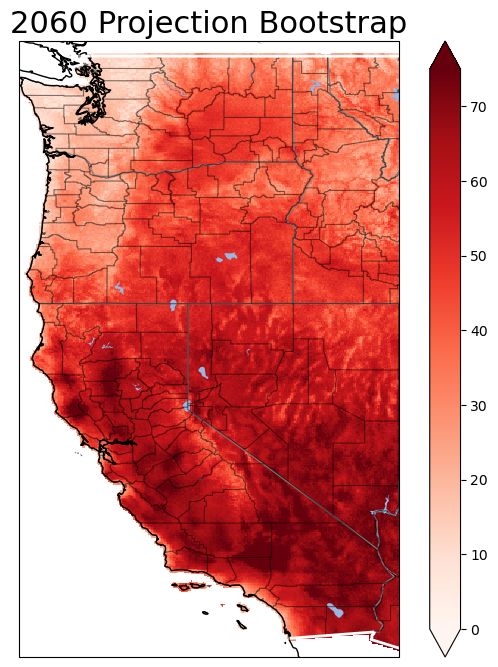

In [10]:
# Number of bootstrap iterations, 18 because 18 CMIP5 models 
num_iterations = 18

num_plots = 1
for i in range(num_plots):
    booted_trend_slope = blank.copy(deep=True)
    # iterates at each point
    for lon in residuals.lon.values:
        for lat in residuals.lat.values:
            # gives me residuals at each point and the predicated value at each point from the gridmet data
            actual_residuals = (residuals.sel(lon=lon, lat=lat, method = 'nearest')).values
            actual_trendline_values = (trendline_values.sel(lon=lon, lat=lat, method = 'nearest')).values
            # Perform bootstrap iterations where projection_2060_array is array of 2060 projections for each bootstrap
            projection_2060_array_internal = []
            for _ in range(num_iterations):
                # Resample with replacement, randomizing the residuals
                resample_indices = np.random.choice(len(actual_residuals), len(actual_residuals), replace=True)
                boot_resid = actual_residuals[resample_indices] 
                resample_all_years = np.random.choice(len(actual_residuals), len(actual_residuals)+38, replace=True)
                boot_resid_allyears = actual_residuals[resample_all_years]
                
                # adding my randomized residuals back to my intial line of best fit for different values
                boot_sl = boot_resid + actual_trendline_values
            
                # Compute bootstrapped trend using np.polyfit (linear fit, degree=1)
                trend_coefficients = np.polyfit(range(len(boot_sl)), boot_sl, 1)
                # takes bootstrap trend projected values to 50 + initial length so to 2060 
                trend = np.polyval(trend_coefficients, range(len(boot_sl) + 38))
                all_values = trend + boot_resid_allyears
                # just takes the 2060 projected value
                projection_2060_internal = all_values[-1]
                # appends projected value at 2060 for each bootstrap to an array so projection_2060_array has 18 values, = amount of models
                projection_2060_array_internal.append(projection_2060_internal)
                
            # finishes with an array with 18 values, and take the average of the 18 2060 projections, replacing my 'blank' array at 
            # the appropriate lon / lat combination
            averaged_2060 = np.mean(projection_2060_array_internal)
            booted_trend_slope.loc[{'lon': lon, 'lat': lat}] = averaged_2060
            



    # then plot booted_trend_slope which is the bootstrapped projection at each location, where each location is an average of the 18 
    # bootstrapped projections
    reader = shpreader.Reader('/data/keeling/a/ctavila2/2_maps/county_shapefile/countyl010g.shp')
    counties = list(reader.geometries())
    COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())
    
    shapefile_path = '/data/keeling/a/ctavila2/4_Model_Trendline/shape/ne_10m_ocean.shp'
    gdf_ocean = gpd.read_file(shapefile_path)
    
    scale = '110m'
    states110 = cfeature.NaturalEarthFeature(
                category='cultural',
                name='admin_1_states_provinces_lines',
                scale=scale,
                facecolor='none',
                edgecolor='r')
    

    cmap='Reds'
   
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    booted_trend_slope.plot(ax=ax,cmap=cmap,vmin=0,vmax=75)

    ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '110m', edgecolor='gray', facecolor='none'))
    ax.coastlines()
    ax.add_feature(cfeature.LAKES)
    ax.add_feature(COUNTIES, linewidth=0.8, alpha=0.5, facecolor='none', edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linewidth=2, edgecolor='white')
    
    
    plt.title('2060 Projection Bootstrap', fontsize=22)
    plt.savefig('/data/keeling/a/ctavila2/2024_FWI_CMIP5_Ensemble_Avila/final_figures/figure_2_2060_2090_spatial_fwi_v2/seven_five/2_b_0_GRIDMET_2060_Bootstrap_FWI_Projection_tmaxrhmin_native_18it_75_intvariabiliy_COMP')
    
